# Import Dataset

In [13]:
import gc
gc.collect()
import subprocess as sp
import os
def get_gpu_memory():
    command = "nvidia-smi --query-gpu=memory.free --format=csv"
    memory_free_info = sp.check_output(command.split()).decode('ascii').split('\n')[:-1][1:]
    memory_free_values = [int(x.split()[0]) for i, x in enumerate(memory_free_info)]
    return memory_free_values

get_gpu_memory()

[11176]

In [14]:
import json
from nltk.corpus import stopwords
import re
import json
from sklearn.utils import shuffle
import numpy as np
import pandas as pd
from collections import Counter
import matplotlib.pyplot as plt
with open('test_dataset.json', 'r') as fp:
    test_dataset = json.load(fp)
with open('train_dataset.json', 'r') as fp:
    train_dataset = json.load(fp)

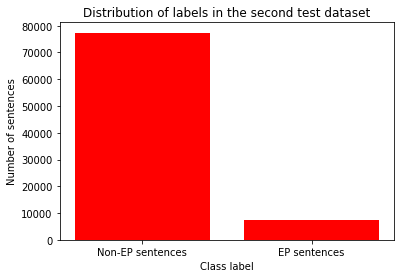

In [15]:
test_dataset_labels=[]
for k,v in test_dataset.items():
    if k=="Environmental Protection":
        for s in v:
            number=1
            test_dataset_labels.append(number)
    else:
        for s in v:
            number=0
            test_dataset_labels.append(number)
unique_labels, counts = np.unique(test_dataset_labels, return_counts=True)
unique_labels=["Non-EP sentences","EP sentences"]
plt.bar(unique_labels, counts,color="r")
plt.xlabel('Class label')
plt.ylabel('Number of sentences')
plt.title('Distribution of labels in the second test dataset')
plt.show()

In [16]:
f = open('/data/data_codebook.json')
data_codebook = json.load(f)
super_set={}
for s in data_codebook:
    if s[2]!="domain_name":
        if s[2] not in super_set:
            super_set[s[2]]=[]
        if s[5] not in super_set[s[2]]:
            super_set[s[2]].append(s[5])

In [17]:
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score, roc_auc_score, classification_report, confusion_matrix
sw = stopwords.words('english')

def clean_text(text):
    
    text = text.lower()
    
    text = re.sub(r"[^a-zA-Z?.!,¿]+", " ", text) # replacing everything with space except (a-z, A-Z, ".", "?", "!", ",")

    text = re.sub(r"http\S+", "",text) #Removing URLs 
    #text = re.sub(r"http", "",text)
    
    html=re.compile(r'<.*?>') 
    
    text = html.sub(r'',text) #Removing html tags
    
    punctuations = '@#!?+&*[]-%.:/();$=><|{}^' + "'`" + '_'
    for p in punctuations:
        text = text.replace(p,'') #Removing punctuations
        
    text = [word.lower() for word in text.split() if word.lower() not in sw]
    
    text = " ".join(text) #removing stopwords
    
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text) #Removing emojis
    
    return text

In [18]:
def calculate_dataset_counts(dataset):
    count_dataset = {
        "general": {},
        "detailed": {}
    }
    
    for s in dataset:
        detailed_label = s['detailed_label']
        general_label = s["general_label"]
        
        if detailed_label not in count_dataset["detailed"]:
            count_dataset["detailed"][detailed_label] = 0
        count_dataset["detailed"][detailed_label] += 1

        if general_label not in count_dataset["general"]:
            count_dataset["general"][general_label] = 0
        count_dataset["general"][general_label] += 1
    
    return count_dataset

In [55]:
def create_custom_dataset(balanced_dataset, total_limit, desired_percentage):
    used_sentences = set()
    dataset = []
    welfare_count = 0
    welfare_limit = int(total_limit * desired_percentage)
    category_limits = {category: 100 for category in balanced_dataset.keys()}

    # Calculate the total number of sentences in the dataset
    total_sentences = sum(len(v) for v in balanced_dataset.values())

    # First, add sentences from 'Environmental Protection'
    for sentence in balanced_dataset['Environmental Protection']:
        if len(dataset) >= welfare_limit:
            break

        if sentence not in used_sentences:
            per_line_dict = {
                "sentence": sentence,
                "detailed_label": 'Environmental Protection',
                "general_label": 'Welfare and Quality of Life'
            }
            dataset.append(per_line_dict)
            used_sentences.add(sentence)
            welfare_count += 1

    # Then, add sentences from other categories
    while len(dataset) < total_limit:
        for category, sentences in balanced_dataset.items():
            if len(dataset) >= total_limit:
                break
            if category != 'Environmental Protection':
                for key, value in super_set.items():
                    if category in value:
                        super_label = key

                category_limit = min(len(sentences), category_limits[category])

                limit = min(100, category_limit)

                for sentence in sentences:
                    if limit == 0 or len(dataset) >= total_limit:
                        break

                    if sentence not in used_sentences:
                        per_line_dict = {
                            "sentence": sentence,
                            "detailed_label": category,
                            "general_label": super_label
                        }
                        dataset.append(per_line_dict)
                        used_sentences.add(sentence)
                        limit -= 1
                        category_limits[category] += 100

    return dataset, welfare_count


In [57]:
"Experiment 1"
total_limit = 56000
desired_percentage = 0.5

dataset, welfare_count = create_custom_dataset(train_dataset, total_limit, desired_percentage)

print("Total sentences in the dataset:", len(dataset))
print("Sentences with 'Welfare and Quality of Life' label:", welfare_count)

# Usage example:
# Assuming you have the 'dataset' variable containing the dataset obtained from the create_custom_dataset function
# Replace this with the actual dataset you want to count.
count_dataset = calculate_dataset_counts(dataset)
print(count_dataset["general"])
print(sum(count_dataset["general"].values()))
print(len(count_dataset["detailed"].keys()))
print(count_dataset["detailed"])

Total sentences in the dataset: 56000
Sentences with 'Welfare and Quality of Life' label: 28000
{'Welfare and Quality of Life': 30511, 'Economy': 6314, 'Fabric of Society': 7079, 'Social Groups': 1931, 'External Relations': 3761, 'Freedom and Democracy': 3241, 'Political System': 3163}
56000
116
{'Environmental Protection': 28000, 'Welfare State Expansion': 400, 'Nationalisation': 400, 'Multiculturalism: Positive': 400, 'Agriculture and Farmers: Positive': 400, 'Incentives: Positive': 400, 'Market Regulation': 400, 'Economic Orthodoxy': 400, 'Technology and Infrastructure: Positive': 400, 'Equality: Positive': 400, 'Culture: Positive': 400, 'Military: Positive': 400, 'Freedom and Human Rights': 400, 'Law and Order: Positive': 400, 'Internationalism: Positive': 400, 'Education Expansion': 400, 'Political Authority: Party Competence': 400, 'Decentralization': 400, 'Free Market Economy': 400, 'Governmental and Administrative Efficiency': 400, 'Civic Mindedness General: Positive': 400, 'La

In [58]:
def text_classification(dataframe, test_data):
    dataframe = pd.DataFrame(data=(dataframe))
    dataframe=shuffle(dataframe).dropna()
    train_sentences=list(dataframe["sentence"])
    train_labels=[]
    for s in list(dataframe["detailed_label"]):
        if s=='Environmental Protection':
            number=1
        else:
            number=0
        train_labels.append(number)
    len(train_sentences)==len(train_labels)

    train_sentences_cleaned=[]
    for s in list(dataframe["sentence"]):
        cleaned=clean_text(s)
        train_sentences_cleaned.append(cleaned)


    X_train, X_test, y_train, y_test = train_test_split(train_sentences_cleaned, train_labels, test_size=0.3, random_state=42)

    # Vectorize the text data using TF-IDF
    vectorizer = TfidfVectorizer()
    X_train_vectorized = vectorizer.fit_transform(X_train)
    X_test_vectorized = vectorizer.transform(X_test)  # Use transform, not fit_transform

    # Train the models
    logreg_model = LogisticRegression(max_iter=1000)
    gnb_model = GaussianNB()
    svc_model = LinearSVC()

    logreg_model.fit(X_train_vectorized, y_train)
    gnb_model.fit(X_train_vectorized.toarray(), y_train)
    svc_model.fit(X_train_vectorized, y_train)

    # Predict on the test set
    logreg_pred = logreg_model.predict(X_test_vectorized)
    gnb_pred = gnb_model.predict(X_test_vectorized.toarray())
    svc_pred = svc_model.predict(X_test_vectorized)

    # Evaluate accuracy
    logreg_accuracy = accuracy_score(y_test, logreg_pred)
    gnb_accuracy = accuracy_score(y_test, gnb_pred)
    svc_accuracy = accuracy_score(y_test, svc_pred)

    # Evaluate F1-score
    logreg_f1_score = f1_score(y_test, logreg_pred, average='weighted')
    gnb_f1_score = f1_score(y_test, gnb_pred, average='weighted')
    svc_f1_score = f1_score(y_test, svc_pred, average='weighted')

    # Evaluate balanced accuracy
    logreg_balanced_accuracy = balanced_accuracy_score(y_test, logreg_pred)
    gnb_balanced_accuracy = balanced_accuracy_score(y_test, gnb_pred)
    svc_balanced_accuracy = balanced_accuracy_score(y_test, svc_pred)

    # Evaluate ROC-AUC score
    logreg_roc_auc_score = roc_auc_score(y_test, logreg_model.predict_proba(X_test_vectorized)[:, 1], multi_class='ovr')
    gnb_roc_auc_score = roc_auc_score(y_test, gnb_model.predict_proba(X_test_vectorized.toarray())[:, 1], multi_class='ovr')
    svc_roc_auc_score = roc_auc_score(y_test, svc_model.decision_function(X_test_vectorized), multi_class='ovr')

    # Print evaluation metrics for Logistic Regression
    print("Logistic Regression Accuracy:", logreg_accuracy)
    print("Logistic Regression F1-Score:", logreg_f1_score)
    print("Logistic Regression Balanced Accuracy:", logreg_balanced_accuracy)
    print("Logistic Regression ROC-AUC Score:", logreg_roc_auc_score)
    print()

    # Print evaluation metrics for Gaussian Naive Bayes
    print("Gaussian Naive Bayes Accuracy:", gnb_accuracy)
    print("Gaussian Naive Bayes F1-Score:", gnb_f1_score)
    print("Gaussian Naive Bayes Balanced Accuracy:", gnb_balanced_accuracy)
    print("Gaussian Naive Bayes ROC-AUC Score:", gnb_roc_auc_score)
    print()

    # Print evaluation metrics for Linear SVC
    print("Linear SVC Accuracy:", svc_accuracy)
    print("Linear SVC F1-Score:", svc_f1_score)
    print("Linear SVC Balanced Accuracy:", svc_balanced_accuracy)
    print("Linear SVC ROC-AUC Score:", svc_roc_auc_score)
    print()

    # Print classification report and confusion matrix for Linear SVC
    print("Linear SVC Classification Report:")
    print(classification_report(y_test, svc_pred))

    print("Linear SVC Confusion Matrix:")
    print(confusion_matrix(y_test, svc_pred))

    print("-----Now test the model on another unseen test sets--------")
    test_dataframe=[]
    for k,v in test_data.items():
        for key, value in super_set.items():
            if k in value:
                super_label = key
        for s in v:
                per_line_dict = {}
                per_line_dict["sentence"] = s
                per_line_dict["detailed_label"] = k
                per_line_dict["general_label"] = super_label
                test_dataframe.append(per_line_dict)
                
    test_dataframe = pd.DataFrame(data=(test_dataframe))
    test_dataframe=shuffle(test_dataframe).dropna()
    test_sentences_cleaned=[]
    for s in list(test_dataframe["sentence"]):
        cleaned=clean_text(s)
        test_sentences_cleaned.append(cleaned)
        
    y_test=[]
    for s in list(test_dataframe["detailed_label"]):
        if s=='Environmental Protection':
            number=1
        else:
            number=0
        y_test.append(number)


    # Vectorize the text data using TF-IDF
    X_vectorized = vectorizer.transform(test_sentences_cleaned)
    svc_pred = svc_model.predict(X_vectorized)

    # Evaluate accuracy
    svc_accuracy = accuracy_score(y_test, svc_pred)

    # Evaluate F1-score
    svc_f1_score = f1_score(y_test, svc_pred, average='weighted')

    # Evaluate balanced accuracy
    svc_balanced_accuracy = balanced_accuracy_score(y_test, svc_pred)

    # Evaluate ROC-AUC score
    svc_roc_auc_score = roc_auc_score(y_test, svc_model.decision_function(X_vectorized), multi_class='ovr')

    # Print evaluation metrics for Linear SVC on the unseen test set
    print("Linear SVC Accuracy on Unseen Test Set:", round(svc_accuracy,2))
    print("Linear SVC F1-Score on Unseen Test Set:", round(svc_f1_score,2))
    print("Linear SVC Balanced Accuracy on Unseen Test Set:", round(svc_balanced_accuracy,2))
    print("Linear SVC ROC-AUC Score on Unseen Test Set:", round(svc_roc_auc_score,2))
    print()

    # Print classification report and confusion matrix for Linear SVC on the unseen test set
    print("Linear SVC Classification Report on Unseen Test Set:")
    print(classification_report(y_test, svc_pred))

    print("Linear SVC Confusion Matrix on Unseen Test Set:")
    print(confusion_matrix(y_test, svc_pred))

In [54]:
text_classification(dataset, test_dataset)

Logistic Regression Accuracy: 0.9260119047619048
Logistic Regression F1-Score: 0.9146724590922611
Logistic Regression Balanced Accuracy: 0.6851059072193796
Logistic Regression ROC-AUC Score: 0.9305385764048509

Gaussian Naive Bayes Accuracy: 0.6920833333333334
Gaussian Naive Bayes F1-Score: 0.7519594702235632
Gaussian Naive Bayes Balanced Accuracy: 0.6782721558202751
Gaussian Naive Bayes ROC-AUC Score: 0.6782721558202751

Linear SVC Accuracy: 0.9339285714285714
Linear SVC F1-Score: 0.9294078906242895
Linear SVC Balanced Accuracy: 0.7596463263511353
Linear SVC ROC-AUC Score: 0.9187253165786395

Linear SVC Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.98      0.96     15104
           1       0.73      0.54      0.62      1696

    accuracy                           0.93     16800
   macro avg       0.84      0.76      0.79     16800
weighted avg       0.93      0.93      0.93     16800

Linear SVC Confusion Matrix:
[[14772  